#Seria-A Prediction


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading the dataset
file_path = '/content/drive/My Drive/I1.csv'
df = pd.read_csv(file_path)

In [ ]:
# file_path = '/content/I1.csv'
# df = pd.read_csv(file_path)
#printing few rows of the dataset
print(df.head())
print(df.info())
print(df.isnull().sum()[df.isnull().sum() > 0])

  Div        Date   Time   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30     Empoli       Verona     0     1   A     0     0   
1  I1  19/08/2023  17:30  Frosinone       Napoli     1     3   A     1     2   
2  I1  19/08/2023  19:45      Genoa   Fiorentina     1     4   A     0     3   
3  I1  19/08/2023  19:45      Inter        Monza     2     0   H     1     0   
4  I1  20/08/2023  17:30       Roma  Salernitana     2     2   D     1     1   

   ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0  ...     1.85 -0.25      2.02      1.91   2.01   1.92     2.03     1.98   
1  ...     2.10  1.00      1.96      1.97   1.97   1.95     2.02     1.98   
2  ...     1.74  0.25      1.79      2.15   1.82   2.13     2.02     2.15   
3  ...     2.38 -1.25      1.92      2.01   1.91   2.02     1.94     2.05   
4  ...     1.68 -1.00      1.95      1.98   1.94   1.98     2.03     2.03   

   AvgCAHH  AvgCAHA  
0     1.94     1.90  
1     1.95  

In [ ]:
# Droping rows with missing target values
df.dropna(subset=['FTR'], inplace=True)

# Separating numeric and non-numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Filling missing values in numeric columns with median
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Filling missing values in non-numeric columns with mode
for col in df.columns:df[col].fillna(df[col].mode()[0], inplace=True)

# Checking if there are any missing values left
print(df.isnull().sum())

print(df.head())




Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
           ..
PCAHA       0
MaxCAHH     0
MaxCAHA     0
AvgCAHH     0
AvgCAHA     0
Length: 105, dtype: int64
  Div        Date   Time   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30     Empoli       Verona     0     1   A     0     0   
1  I1  19/08/2023  17:30  Frosinone       Napoli     1     3   A     1     2   
2  I1  19/08/2023  19:45      Genoa   Fiorentina     1     4   A     0     3   
3  I1  19/08/2023  19:45      Inter        Monza     2     0   H     1     0   
4  I1  20/08/2023  17:30       Roma  Salernitana     2     2   D     1     1   

   ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0  ...     1.85 -0.25      2.02      1.91   2.01   1.92     2.03     1.98   
1  ...     2.10  1.00      1.96      1.97   1.97   1.95     2.02     1.98   
2  ...     1.74  0.25      1.79      2.15   1.82   2.13     2.02     2.15   
3  ...     2.38 -1.25      1.92

In [ ]:
#Getting day on which match was played from the matchDate and strong that in matchDay column
df["matchDate"] = pd.to_datetime( df["Date"], dayfirst=True)
df['matchDay'] = df['matchDate'].dt.day_name()
df.drop('Date', axis=1, inplace=True)
df.drop('matchDate', axis=1, inplace=True)

df.head()

<ipython-input-33-71caf1ad4bf4>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['matchDay'] = df['matchDate'].dt.day_name()


,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,matchDay
0,I1,17:30,Empoli,Verona,0,1,A,0,0,D,...,-0.25,2.02,1.91,2.01,1.92,2.03,1.98,1.94,1.90,Saturday
1,I1,17:30,Frosinone,Napoli,1,3,A,1,2,A,...,1.00,1.96,1.97,1.97,1.95,2.02,1.98,1.95,1.89,Saturday
2,I1,19:45,Genoa,Fiorentina,1,4,A,0,3,A,...,0.25,1.79,2.15,1.82,2.13,2.02,2.15,1.86,2.00,Saturday
3,I1,19:45,Inter,Monza,2,0,H,1,0,H,...,-1.25,1.92,2.01,1.91,2.02,1.94,2.05,1.87,1.98,Saturday
4,I1,17:30,Roma,Salernitana,2,2,D,1,1,D,...,-1.00,1.95,1.98,1.94,1.98,2.03,2.03,1.92,1.93,Sunday


In [ ]:
#keywords to drop
keywords_drop = ['B365', 'BW', 'IW', 'PS', 'WH', 'VC', 'Max', 'Avg', 'P>2.5', 'P<2.5', 'AHh', 'AHH', 'AHA', 'CH', 'CD', 'CA', 'C>2.5', 'C<2.5','AHCh']

# Creating a list of columns to drop
columns_to_drop = [col for col in df.columns if any(keyword in col for keyword in keywords_drop)]
df = df.drop(columns=columns_to_drop)

#one=hot encoding for the below attributes
df = pd.get_dummies(df, columns=['HomeTeam'], prefix = ['HomeTeam'],dtype=int)
df = pd.get_dummies(df, columns=['AwayTeam'], prefix = ['AwayTeam'],dtype=int)
df = pd.get_dummies(df, columns=['HTR'], prefix = ['HTR'],dtype=int)
df = pd.get_dummies(df, columns=['matchDay'], prefix = ['matchDay'],dtype=int)
print(df.head())

#label encoding of the attribute FTR(target attribute)
label_encoder = LabelEncoder()
df['FTR']= label_encoder.fit_transform(df['FTR'])

  Div   Time  FTHG  FTAG FTR  HTHG  HTAG  HS  AS  HST  ...  HTR_A  HTR_D  \
0  I1  17:30     0     1   A     0     0  10  10    4  ...      0      1   
1  I1  17:30     1     3   A     1     2   4  19    1  ...      1      0   
2  I1  19:45     1     4   A     0     3   4   9    2  ...      1      0   
3  I1  19:45     2     0   H     1     0  22  12    3  ...      0      0   
4  I1  17:30     2     2   D     1     1  13   3    3  ...      0      1   

   HTR_H  matchDay_Friday  matchDay_Monday  matchDay_Saturday  \
0      0                0                0                  1   
1      0                0                0                  1   
2      0                0                0                  1   
3      1                0                0                  1   
4      0                0                0                  0   

   matchDay_Sunday  matchDay_Thursday  matchDay_Tuesday  matchDay_Wednesday  
0                0                  0                 0                   

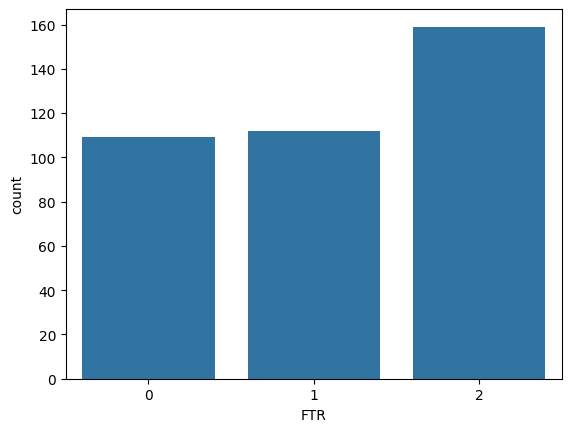

In [ ]:
import tensorflow as tf
sns.countplot(x='FTR',data=df)

X = df.drop(['FTR','Div','Time'],axis=1)
y = df['FTR']

X_standardized = StandardScaler().fit_transform(X)


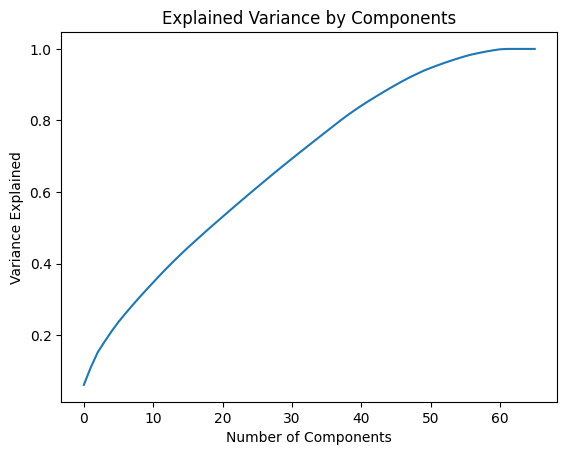

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to determine the optimal number of components
pca = PCA().fit(X_standardized)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Components')
plt.show()


In [ ]:
#Taking 60 components from training
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X_standardized)

In [ ]:
# Split the dataset. 80 % to training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

print("The shape of X_train is " + str(X_train.shape))
print("The size of y_train is " + str(y_train.shape))
print("The size of X_test set is " + str(X_test.shape))
print("The size of y_test is " + str(y_test.shape))


The shape of X_train is (304, 60)
The size of y_train is (304,)
The size of X_test set is (76, 60)
The size of y_test is (76,)


Accuracy: 0.6578947368421053
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.60      0.24      0.34        25
           2       0.62      0.97      0.76        29

    accuracy                           0.66        76
   macro avg       0.66      0.64      0.61        76
weighted avg       0.66      0.66      0.62        76



<Axes: >

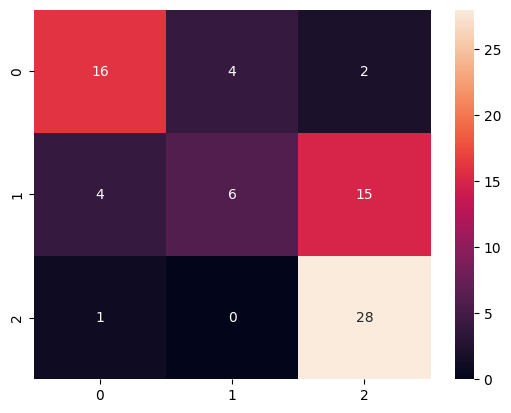

In [ ]:
#training with random forest classifier
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


Accuracy: 0.6578947368421053
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71        22
           1       0.50      0.40      0.44        25
           2       0.69      0.86      0.77        29

    accuracy                           0.66        76
   macro avg       0.65      0.65      0.64        76
weighted avg       0.65      0.66      0.65        76



<Axes: >

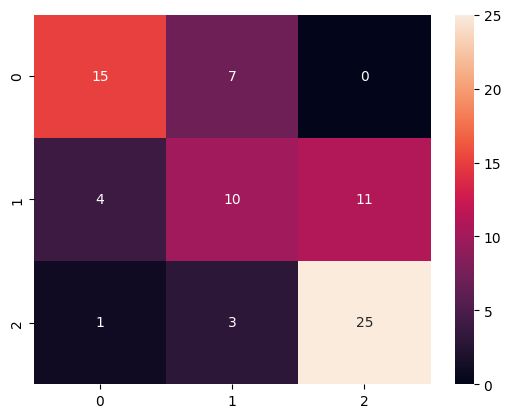

In [ ]:
#training with gradient boost classifier
from sklearn.ensemble import GradientBoostingClassifier
model_gb = GradientBoostingClassifier(n_estimators=200)
model_gb.fit(X_train, y_train)
y_pred=model_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


In [ ]:
#chaning the target columns into categorical for classfication
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.3601 - loss: 1.7962 - val_accuracy: 0.3115 - val_loss: 1.8193
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4421 - loss: 1.7813 - val_accuracy: 0.3115 - val_loss: 1.8163
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4471 - loss: 1.7675 - val_accuracy: 0.3279 - val_loss: 1.8143
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3865 - loss: 1.7853 - val_accuracy: 0.3115 - val_loss: 1.8122
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4646 - loss: 1.7432 - val_accuracy: 0.3279 - val_loss: 1.8099
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4899 - loss: 1.7394 - val_accuracy: 0.3279 - val_loss: 1.8084
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5213 - loss: 1.7262 - val_accuracy: 0.3279 - val_loss: 1.8066
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5229 - loss: 1.6976 - val_accuracy: 0.3279 - val_loss:

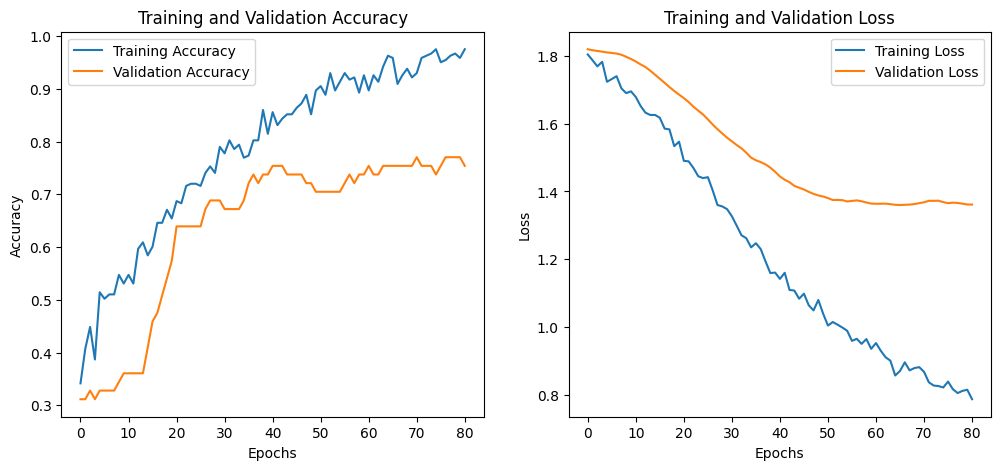

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

#training with neural network
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model with lower learning rate and gradient clipping
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

#early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Define callbacks with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with increased batch size and callbacks
history = model2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # Increased batch size
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
score = model2.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7644 - loss: 1.2374 
Test Score: 1.3203588724136353
Test Accuracy: 0.7631579041481018


In [ ]:
#generating classifcation report
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model2.predict(X_test)

y_pred_class = tf.argmax(y_pred, axis=1)

y_test_class = tf.argmax(y_test, axis=1)

report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        22
           1       0.61      0.80      0.69        25
           2       0.88      0.76      0.81        29

    accuracy                           0.76        76
   macro avg       0.79      0.76      0.77        76
weighted avg       0.79      0.76      0.77        76



In [ ]:
#predicting the result
row_index = 3  # Change this to the row index you want to select
Xnew = X.iloc[row_index, :].to_numpy().reshape(1, -1)
# Apply the same PCA transformation used during training
Xnew_pca = pca.transform(Xnew)
ynew = np.argmax(model2.predict(Xnew_pca),axis=-1)

# Show the inputs and predicted outputs
print("X = %s" % Xnew)
print("Prediction = %s" % ynew[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
X = [[ 2  0  1  0 22 12  3  2  8 13  8  3  1  1  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0]]
Prediction = 1


Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.4554 - loss: 18.6760 - val_accuracy: 0.3115 - val_loss: 18.6009 - learning_rate: 1.0000e-04
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4170 - loss: 18.4805 - val_accuracy: 0.3115 - val_loss: 18.3489 - learning_rate: 1.0000e-04
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4543 - loss: 18.2213 - val_accuracy: 0.3115 - val_loss: 18.1061 - learning_rate: 1.0000e-04
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4929 - loss: 17.9493 - val_accuracy: 0.3279 - val_loss: 17.8713 - learning_rate: 1.0000e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4346 - loss: 17.7426 - val_accuracy: 0.3279 - val_loss: 17.6426 - learning_rate: 1.0000e-04
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4464 - loss: 17.5373 - val_accuracy: 0.3443 - val_loss: 17.4194 - learning_rate: 1.0000e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0

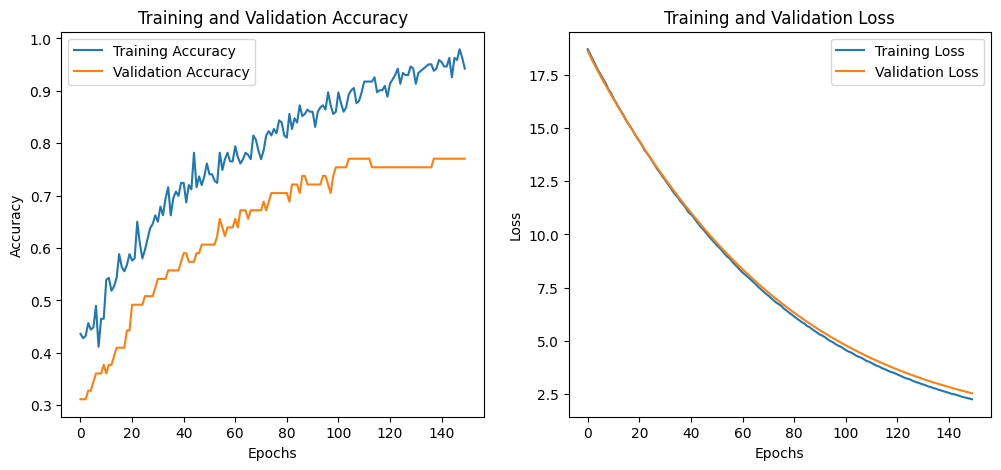

In [ ]:
#sequential model with different parameter
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.05)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.05)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.05)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with the learning rate schedule
model6.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

# Callbacks for early stopping and learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with callbacks
history = model6.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3102 - loss: 1.2422 - val_accuracy: 0.3279 - val_loss: 1.1794 - learning_rate: 1.0000e-04
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3248 - loss: 1.2590 - val_accuracy: 0.2951 - val_loss: 1.1681 - learning_rate: 1.0000e-04
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3843 - loss: 1.1717 - val_accuracy: 0.3115 - val_loss: 1.1595 - learning_rate: 1.0000e-04
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4167 - loss: 1.1049 - val_accuracy: 0.3443 - val_loss: 1.1561 - learning_rate: 1.0000e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4543 - loss: 1.0882 - val_accuracy: 0.3607 - val_loss: 1.1555 - learning_rate: 1.0000e-04
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4245 - loss: 1.0990 - val_accuracy: 0.3770 - val_loss: 1.1542 - learning_rate: 1.0000e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4398 - loss: 1.10

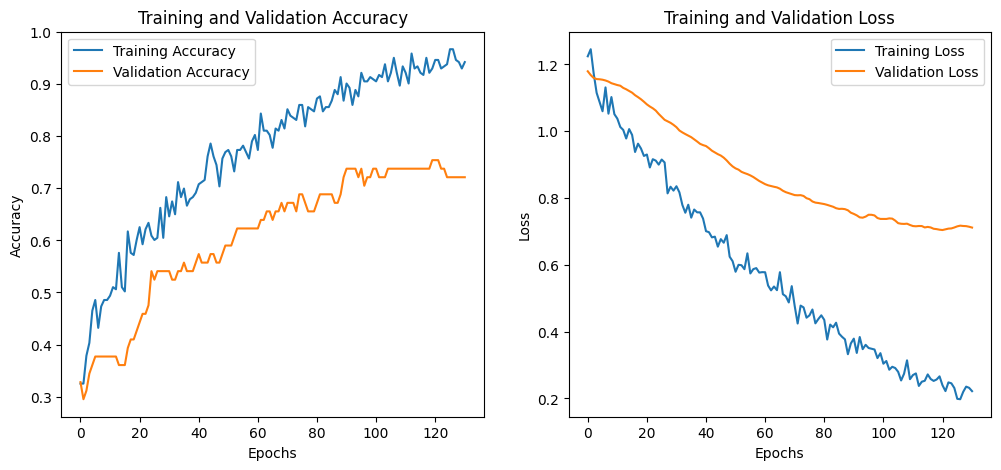

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Updated model architecture with different parameter
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.0001)),  # Increased units
    tf.keras.layers.Dropout(0.2),  # Adjusted dropout
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.0001)),  # Adjusted units
    tf.keras.layers.Dropout(0.3),  # Adjusted dropout
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.0001)),  # Adjusted units
    tf.keras.layers.Dropout(0.4),  # Adjusted dropout
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model with AdamW optimizer and fixed learning rate
model9.compile(
    loss='categorical_crossentropy',
    optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-4),  # Use fixed learning rate
    metrics=['accuracy']
)

# Callbacks for early stopping and learning rate adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with callbacks
history = model9.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
#this model is better than other ones
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model9.predict(X_test)

y_pred_class = tf.argmax(y_pred, axis=1)

y_test_class = tf.argmax(y_test, axis=1)

report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        22
           1       0.52      0.52      0.52        25
           2       0.79      0.79      0.79        29

    accuracy                           0.68        76
   macro avg       0.68      0.68      0.68        76
weighted avg       0.68      0.68      0.68        76



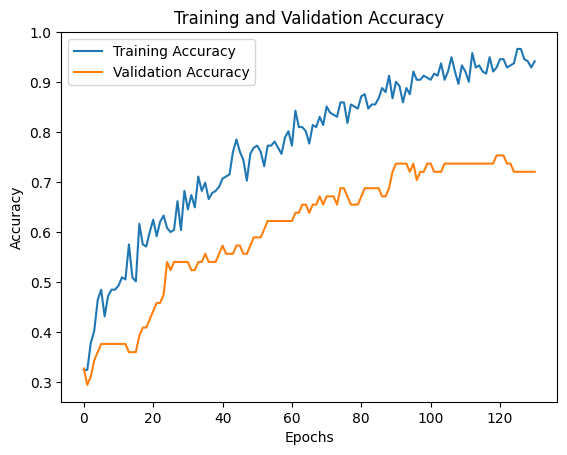

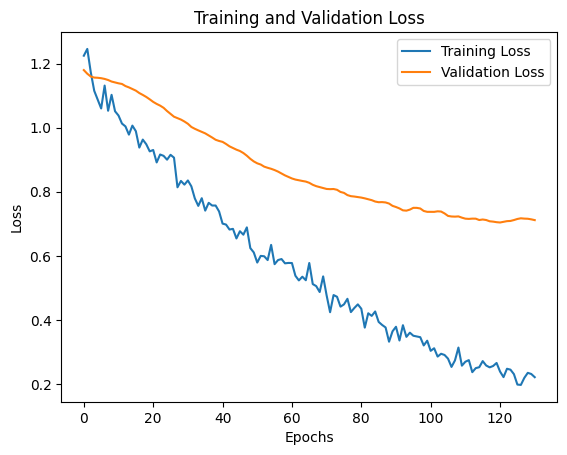

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
model9.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,891 (667.55 KB)

 Trainable params: 56,963 (222.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 113,928 (445.04 KB)